In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GaussianNoise
import tensorflow.keras.backend as K
import tensorflow as tf
from functools import partial

Welcome to JupyROOT 6.10/08


In [2]:
n_particles = 100000/2
p = np.random.uniform(0.3,10.,n_particles)
mp = np.random.uniform(1/10.,1/0.3,n_particles)
p_mp = 1./mp 

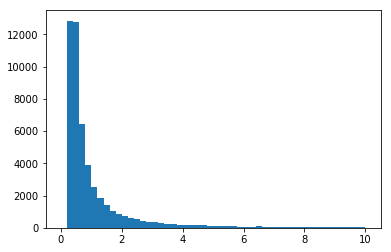

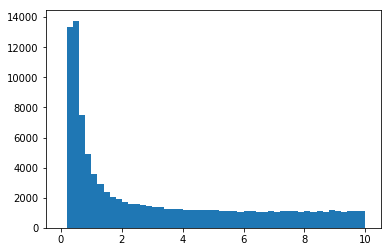

In [3]:
plt.hist(p_mp,50,range=(0.,10.))
plt.show()
p_ges = np.concatenate([p,p_mp])
plt.hist(p_ges,50,range=(0,10))
plt.show()

In [4]:
mass_pi = 0.139
mass_mu = 0.105
mass_e = 0.000511
mass_p = 0.938
mass_K = 0.494
masses = [mass_pi, mass_mu, mass_e, mass_p, mass_K]
masses

[0.139, 0.105, 0.000511, 0.938, 0.494]

In [5]:
signals = []
for mass in masses:
    ITS_tmp = []
    TPCROC0_tmp = []
    TPCROC1_tmp = []
    TPCROC2_tmp = []
    TRD_tmp = []
    TOF_tmp = []
    for p in p_ges:
        bg = p/mass
        beta = bg/math.sqrt(1.+ bg*bg);
        BBS = ROOT.AliExternalTrackParam.BetheBlochSolid(bg)
        BBA = ROOT.AliExternalTrackParam.BetheBlochAleph(bg)
        ITS_tmp.append(np.random.normal(BBS,0.1*BBS) ) ## ITS dEdx = smeared gaus 10% 
        TPCROC0_tmp.append(np.random.normal(BBA,0.1*BBA) )## TPC dEdx = smeared gaus 10% for 1st layer
        TPCROC1_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 2nd layer
        TPCROC2_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 3d layer
        TRD_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TRD dEdx = smeared gaus 10% 
        TOF_tmp.append(np.random.normal(beta,0.1*beta) )  ## TOF - smeared with .... gaussian
    signals.append({'ITS': ITS_tmp, 'TPCROC0': TPCROC0_tmp, 'TPCROC1': TPCROC1_tmp, 'TPCROC1': TPCROC1_tmp, 
                    'TPCROC2': TPCROC2_tmp, 'TRD': TRD_tmp, 'TOF': TOF_tmp})

[]

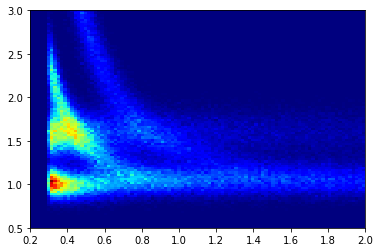

In [6]:
df_list=[]
for i, val in enumerate(masses):
    df = pd.DataFrame.from_dict(signals[i])
    df['p'] = pd.Series(p_ges, index=df.index)
    df['particle'] = pd.Series(i, index=df.index)
    df_list.append(df)
df_all = pd.concat([df_list[0],df_list[2],df_list[3],df_list[4]], ignore_index=True)
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.plot()

In [7]:
N=len(df_all)
probabilty = 0.95

flips_raw = (1*(np.random.random(size=6*N)<probabilty)).reshape(6,-1)

flips=flips_raw[0]
for i in range(1,6):
    # (1<<i = 2**i)
    flips=flips_raw[i]*(1<<i) + flips


df_all.loc[:,'flips']=flips
df_all.head(5)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips
0,0.001986,0.928901,1.306780,1.352975,1.494461,1.360862,8.028624,0,31
1,0.002366,0.873853,1.328811,1.225591,1.425643,1.452342,9.074399,0,63
2,0.002163,1.042987,1.217976,1.487496,1.407477,1.170897,6.435546,0,63
3,0.001829,1.109198,1.280903,1.157635,1.174755,1.237034,2.696623,0,63
4,0.002065,0.911702,1.397673,1.305126,1.313024,1.377635,6.204195,0,63


In [31]:
# prepare "flips-Data" and weights
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_all['flips'])>>i)&1
    # if f=0 substitute value by mean
    m=df_all[name].mean()
    print(m)
    df_all.loc[:,name+'_mr']= df_all[name].multiply(f,axis='index')+m*(1-f) #mean replaced
    df_all.loc[:,name+'_w']=1.0*f #weight
    df_all.loc[:,name+'_0']= df_all[name].multiply(f,axis='index') #zeros
    
# generate data for stage 2
df_stage_2=df_all.copy()
df_stage_3=df_all.copy()
df_all[df_all['particle']==0].head(40)

0.002524336670232131
0.9024631876856233
1.4816737592212283
1.481875736006395
1.4816772694593963
1.4820196775579728


,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,ITS_mr,...,TPCROC0_0,TPCROC1_mr,TPCROC1_w,TPCROC1_0,TPCROC2_mr,TPCROC2_w,TPCROC2_0,TRD_mr,TRD_w,TRD_0
0,0.001986,0.928901,1.306780,1.352975,1.494461,1.360862,8.028624,0,31,0.001986,...,1.306780,1.352975,1.0,1.352975,1.494461,1.0,1.494461,1.482020,0.0,0.000000
1,0.002366,0.873853,1.328811,1.225591,1.425643,1.452342,9.074399,0,63,0.002366,...,1.328811,1.225591,1.0,1.225591,1.425643,1.0,1.425643,1.452342,1.0,1.452342
2,0.002163,1.042987,1.217976,1.487496,1.407477,1.170897,6.435546,0,63,0.002163,...,1.217976,1.487496,1.0,1.487496,1.407477,1.0,1.407477,1.170897,1.0,1.170897
3,0.001829,1.109198,1.280903,1.157635,1.174755,1.237034,2.696623,0,63,0.001829,...,1.280903,1.157635,1.0,1.157635,1.174755,1.0,1.174755,1.237034,1.0,1.237034
4,0.002065,0.911702,1.397673,1.305126,1.313024,1.377635,6.204195,0,63,0.002065,...,1.397673,1.305126,1.0,1.305126,1.313024,1.0,1.313024,1.377635,1.0,1.377635
5,0.002154,0.978778,1.433307,1.261741,1.417941,1.266195,4.476341,0,63,0.002154,...,1.433307,1.261741,1.0,1.261741,1.417941,1.0,1.417941,1.266195,1.0,1.266195
6,0.001904,1.092588,1.238779,1.171434,1.198615,1.402802,3.350004,0,63,0.001904,...,1.238779,1.171434,1.0,1.171434,1.198615,1.0,1.198615,1.402802,1.0,1.402802
7,0.001914,1.021798,1.286898,1.160598,1.333520,1.525956,8.449146,0,63,0.001914,...,1.286898,1.160598,1.0,1.160598,1.333520,1.0,1.333520,1.525956,1.0,1.525956
8,0.002215,0.939650,1.367377,1.237790,1.234805,1.410477,8.678505,0,63,0.002215,...,1.367377,1.237790,1.0,1.237790,1.234805,1.0,1.234805,1.410477,1.0,1.410477
9,0.002150,0.982940,1.221028,1.225464,1.212382,1.426775,8.141874,0,63,0.002150,...,1.221028,1.225464,1.0,1.225464,1.212382,1.0,1.212382,1.426775,1.0,1.426775


In [9]:
train, test =train_test_split(df_all, test_size=0.5)

# Create autoencoders

In [10]:
def custom_loss(y_true, y_pred,weights):
    return K.mean(K.square((y_true - y_pred)*weights))

inputs = Input(shape=(6,))
inputw = Input(shape=(6,))
noise = GaussianNoise(0.2)(inputs)
enc1   = Dense(units=64, activation='selu')(noise)
enc2   = Dense(units=64, activation='selu')(enc1)
enc3   = Dense(units=64, activation='selu')(enc2)
enc4   = Dense(units=64, activation='selu')(enc3)
layer0 = Dense(units=2 , activation='selu')(enc4)
dec1   = Dense(units=64, activation='selu')(layer0)
dec2   = Dense(units=64, activation='selu')(dec1)
dec3   = Dense(units=64, activation='selu')(dec2)
dec4   = Dense(units=64, activation='selu')(dec3)
outputs= Dense(units=6, activation='linear')(dec4)

c_loss = partial(custom_loss, weights=inputw)
        
modelpt = Model(inputs=inputs,outputs=outputs)
models2 = Model(inputs=inputs,outputs=outputs)
modell = Model(inputs=inputs,outputs=outputs)
model0 = Model(inputs=inputs,outputs=outputs)
model1 = Model(inputs=[inputs,inputw],outputs=outputs)
modelpt.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
models2.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
modell.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model0.compile(loss='mse',
              optimizer='adam',
              metrics=['mse'])
model1.compile(loss=c_loss,
              optimizer='adam',
              metrics=['mse'])

In [11]:
model0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6)                 0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 64)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
__________

# perfect tracks

In [12]:
train_pt = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_pt = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_pt = StandardScaler()
scaler_pt.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
modelpt.fit(scaler_pt.transform(train_pt), scaler_pt.transform(train_pt), epochs=5, batch_size=32, 
          validation_data=[scaler_pt.transform(test_pt),scaler_pt.transform(test_pt)])

Train on 200000 samples, validate on 200000 samples
Epoch 1/5
200000/200000 [==============================] - 55s 275us/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0341 - val_mean_squared_error: 0.0341
Epoch 2/5
200000/200000 [==============================] - 53s 265us/step - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.0386 - val_mean_squared_error: 0.0386
Epoch 3/5
200000/200000 [==============================] - 53s 265us/step - loss: 0.0423 - mean_squared_error: 0.0423 - val_loss: 0.0326 - val_mean_squared_error: 0.0326
Epoch 4/5
200000/200000 [==============================] - 53s 263us/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0323 - val_mean_squared_error: 0.0323
Epoch 5/5
200000/200000 [==============================] - 53s 265us/step - loss: 0.0415 - mean_squared_error: 0.0415 - val_loss: 0.0324 - val_mean_squared_error: 0.0324


2019-01-30 14:13:28.150690: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA


In [14]:
out = scaler_pt.inverse_transform(modelpt.predict(scaler_pt.transform(test_pt)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,131875,0.002921,0.922414,1.908985,1.917489,1.586650,1.661366,9.594798,2,63,...,1.586650,1.661366,1.0,1.661366,0.002931,0.937709,1.628854,1.653911,1.628246,1.674449
1,333109,0.001686,0.883795,1.059419,1.275309,1.246488,1.095858,6.228932,4,63,...,1.246488,1.095858,1.0,1.095858,0.001884,0.892631,1.134143,1.126649,1.129369,1.134250
2,43361,0.002228,0.900896,1.123925,1.380433,1.642345,1.303734,4.442970,0,63,...,1.642345,1.303734,1.0,1.303734,0.002230,0.917134,1.353219,1.342327,1.347069,1.358386


In [21]:
df_test.columns

Index([u'index', u'ITS', u'TOF', u'TPCROC0', u'TPCROC1', u'TPCROC2', u'TRD',
       u'p', u'particle', u'flips', u'ITS_mr', u'ITS_w', u'ITS_0', u'TOF_mr',
       u'TOF_w', u'TOF_0', u'TPCROC0_mr', u'TPCROC0_w', u'TPCROC0_0',
       u'TPCROC1_mr', u'TPCROC1_w', u'TPCROC1_0', u'TPCROC2_mr', u'TPCROC2_w',
       u'TPCROC2_0', u'TRD_mr', u'TRD_w', u'TRD_0', u'ITS_ae', u'TOF_ae',
       u'TPCROC0_ae', u'TPCROC1_ae', u'TPCROC2_ae', u'TRD_ae'],
      dtype='object')

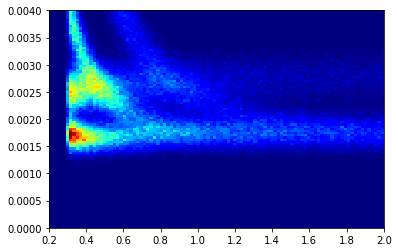

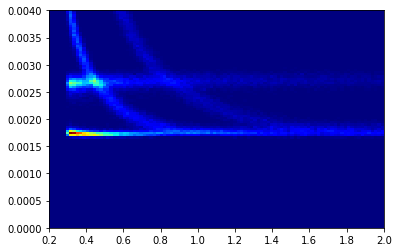

In [20]:
plt.hist2d(df_all["p"], df_all["ITS"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0., 0.004]])
plt.savefig("before.pdf")
plt.show()
plt.hist2d(df_test["p"], df_test["ITS_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0, 0.004]])
plt.savefig("after.pdf")
plt.show()

# Train with zeros

In [ ]:
train_0 = train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
test_0 = test[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
scaler_0 = StandardScaler()
scaler_0.fit( train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]])
#scaler_0.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]) 

In [ ]:
train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]].head()

In [ ]:
train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]].head()


In [ ]:
model0.fit(scaler_0.transform(train_0), scaler_0.transform(train_0), epochs=5, batch_size=32, 
          validation_data=[scaler_0.transform(test_0),scaler_0.transform(test_0)])

In [ ]:
out = scaler_0.inverse_transform(model0.predict(scaler_0.transform(test_0)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# labels for missing tracks

In [ ]:
train_in = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_out = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_in = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_out = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_in = StandardScaler()
scaler_out = StandardScaler()
scaler_in.fit(train_in)
scaler_out.fit(train_out)

In [ ]:
modell.fit(scaler_in.transform(train_in), scaler_out.transform(train_out), epochs=5, batch_size=32, 
          validation_data=[scaler_in.transform(test_in),scaler_out.transform(test_out)])

In [ ]:
out = scaler_out.inverse_transform(modell.predict(scaler_in.transform(test_in)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# mean input, zero weights for missing values

In [ ]:
train_mr = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_mr = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_w    = train[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]
test_w     = test[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]

In [ ]:
scaler_mr = StandardScaler()
scaler_mr.fit(train_mr)

In [ ]:
model1.fit([scaler_mr.transform(train_mr),train_w], scaler_mr.transform(train_mr), epochs=5, batch_size=32, 
          validation_data=[[scaler_mr.transform(test_mr),train_w],scaler_mr.transform(test_mr)])

In [ ]:
out = scaler_mr.inverse_transform(model1.predict([scaler_mr.transform(test_mr),test_w]))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# second iteration, replace missing values by values from first iteration

In [ ]:
# stage 2
stage2_data = df_stage_2[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
out = scaler_mr.inverse_transform(models2.predict(scaler_mr.transform(stage2_data)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_stage_2['flips'])>>i)&1
    m=AE_predict[name+'_ae']
    df_stage_2.loc[:,name+'_s2']= df_stage_2[name].multiply(f,axis='index')+m*(1-f)

In [ ]:
train, test =train_test_split(df_stage_2, test_size=0.5)
train_s2 = train[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]
test_s2 = test[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]

In [ ]:
scaler_s2 = StandardScaler()
scaler_s2.fit(train_s2)
models2.fit(scaler_s2.transform(train_s2), scaler_s2.transform(train_s2), epochs=5, batch_size=32, 
          validation_data=[scaler_s2.transform(test_s2),scaler_s2.transform(test_s2)])

In [ ]:
out = scaler_s2.inverse_transform(models2.predict(scaler_s2.transform(test_s2)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# Correlations

In [ ]:
print(df_test.query("p>1. and p <1.05")[['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']].corr())

In [ ]:
print(df_test.query("p>1. and p <1.05")[["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]].corr())

# Classification test

In [ ]:
trainRF, testRF = train_test_split(df_test, test_size = 0.5)
RF_before = RandomForestClassifier(n_estimators=100, max_depth=10)
RF_after = RandomForestClassifier(n_estimators=100, max_depth=10)
RF_before.fit(trainRF[['ITS_0','TOF_0','TPCROC0_0','TPCROC1_0','TPCROC2_0','TRD_0']],np.ravel(trainRF[["particle"]]))
RF_after.fit(trainRF[["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]],np.ravel(trainRF[["particle"]]))

In [ ]:
RF_before.score(testRF[['ITS_0','TOF_0','TPCROC0_0','TPCROC1_0','TPCROC2_0','TRD_0']],np.ravel(testRF[["particle"]]))

In [ ]:
RF_after.score(testRF[["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]],np.ravel(testRF[["particle"]]))